# LoRA Fine-Tuning - Phishing Email Detection with QLoRA + Gemma
### By Colin Harrison, Aidan Huerta, and Drew Levy
---
This notebook fine-tunes `google/gemma-3-1b-it` using **QLoRA** (Quantized Low-Rank Adaptation).

Instead of updating all ~1B parameters, LoRA freezes the base model and trains small low-rank adapter matrices

We use a **2,000 sample subset** of the phishing dataset (1,600 train / 200 val / 200 test).

## Install Dependencies

In [ ]:
# Run this cell first — installs LoRA and quantization libraries
!pip install -q peft bitsandbytes transformers accelerate tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 10.4 MB/s eta 0:00:00


In [ ]:
print("Importing necessary libraries...\n")

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import login
from tqdm import tqdm

print("Done!")

Importing necessary libraries...

Done!


## Load & Subset Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_df = pd.read_csv('/content/drive/MyDrive/Phishing_Email.csv')
data_df = data_df.dropna(subset=["Email Text"])

# Sample 2,000 total — stratified to preserve class balance
subset_df, _ = train_test_split(data_df, train_size=2000, stratify=data_df["Email Type"], random_state=42)

# 80 / 10 / 10 split
train_df, temp_df = train_test_split(subset_df, train_size=0.8, stratify=subset_df["Email Type"], random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Email Type"], random_state=42)

pd.set_option('display.max_colwidth', 70)
print("Training Data shape:",   train_df.shape)
print("Validation Data shape:", validation_df.shape)
print("Testing Data shape:",    test_df.shape)
print()
print("Class distribution in training set:")
print(train_df["Email Type"].value_counts())
print()
print("Below is a small sample of what the data we will be using looks like:")
print(train_df.sample(n=5))

Mounted at /content/drive
Training Data shape: (1600, 3)
Validation Data shape: (200, 3)
Testing Data shape: (200, 3)

Class distribution in training set:
Email Type
Safe Email        972
Phishing Email    628
Name: count, dtype: int64

Below is a small sample of what the data we will be using looks like:
       Unnamed: 0  \
11555       11556   
14966       14967   
7035         7036   
17885       17886   
8560         8561   

                                                                  Email Text  \
11555  \nShopper Newsletter: AlertsLive tech help NOW!\nApril's tech awar...   
14966  [Tim]\n> Another area for potentially fruitful study:  it's clear ...   
7035   make $ 472 hello , we sent you an email a while ago , because you ...   
17885  80 % off of everything discount drugs . . . save 80 % every order ...   
8560   [Jeremy Hylton]\n> Here's clarification of why I did:That's pretty...   

           Email Type  
11555      Safe Email  
14966      Safe Email  
7035   Phishi

## Load Gemma in 4-bit (QLoRA)

In [7]:
login(token="place_hf_token_here")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_NAME = "google/gemma-3-1b-it"
MAX_LEN    = 256
BATCH_SIZE = 4  # change during testing
EPOCHS     = 3
LR         = 2e-4

# 4-bit quantization config (QLoRA)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

print(f"\nLoading {MODEL_NAME} in 4-bit...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
base_model.config.use_cache = False
print("Base model loaded!")

Using device: cuda

Loading google/gemma-3-1b-it in 4-bit...


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/340 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Base model loaded!


## Apply LoRA Adapters
LoRA injects trainable low-rank matrices into the attention layers.
Only ~0.1% of parameters will actually be trained.

In [8]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,                          # rank: higher = more expressive but more params
    lora_alpha=32,                # scaling factor
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"]   # inject into query and value projections
)

model = get_peft_model(base_model, lora_config)

# Show how few params we're actually training
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable:,} / {total:,} ({100 * trainable / total:.3f}%)")

Trainable parameters: 745,472 / 651,750,528 (0.114%)


## Dataset — Instruction-Style Prompts
We format each email as a labeled completion so the model learns to generate `Safe` or `Phishing`.

In [9]:
def make_prompt(email_text, label=None):
    """
    During training: include the label so the model learns to complete it.
    During evaluation: don't include the label so the model generates it.
    """
    prompt = f"""Classify this email as \"Safe\" or \"Phishing\".\nEmail: {email_text[:400]}\nAnswer:"""
    if label is not None:
        prompt += f" {label}"
    return prompt


class PhishingLoRADataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.samples = []
        for _, row in df.iterrows():
            label = "Phishing" if row["Email Type"] == "Phishing Email" else "Safe"
            text  = make_prompt(str(row["Email Text"]), label=label)
            enc   = tokenizer(
                text,
                max_length=max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            input_ids = enc["input_ids"].squeeze()
            # Labels = input_ids shifted; mask padding with -100 so loss ignores it
            labels = input_ids.clone()
            labels[labels == tokenizer.pad_token_id] = -100
            self.samples.append({
                "input_ids":      input_ids,
                "attention_mask": enc["attention_mask"].squeeze(),
                "labels":         labels
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


print("Building datasets...")
train_dataset = PhishingLoRADataset(train_df,      tokenizer, MAX_LEN)
val_dataset   = PhishingLoRADataset(validation_df, tokenizer, MAX_LEN)
test_dataset  = PhishingLoRADataset(test_df,       tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Building datasets...
Train batches: 400 | Val batches: 50 | Test batches: 50


## Training Loop

In [10]:
optimizer   = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler   = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps)

train_losses = []

print(f"Starting LoRA fine-tuning for {EPOCHS} epochs...\n")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss    = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

print("\nFine-tuning complete!")

Starting LoRA fine-tuning for 3 epochs...



Epoch 1/3: 100%|██████████| 400/400 [07:49<00:00,  1.17s/it]


Epoch 1 | Avg Loss: 3.4544


Epoch 2/3: 100%|██████████| 400/400 [07:53<00:00,  1.18s/it]


Epoch 2 | Avg Loss: 3.0239


Epoch 3/3: 100%|██████████| 400/400 [07:53<00:00,  1.18s/it]

Epoch 3 | Avg Loss: 2.9297

Fine-tuning complete!


## Evaluation

In [11]:
def classify_email(email_text):
    prompt = make_prompt(email_text)   # no label — model must generate it
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = response[len(prompt):].strip().lower()

    return 1 if "phishing" in response else 0


print("Evaluating model on test set...")
predictions, true_labels = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pred       = classify_email(str(row["Email Text"]))
    true_label = 1 if row["Email Type"] == "Phishing Email" else 0
    predictions.append(pred)
    true_labels.append(true_label)

print()
print("Test Accuracy:", accuracy_score(true_labels, predictions))
print("Test AUROC:",    roc_auc_score(true_labels, predictions))

Evaluating model on test set...


100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


Test Accuracy: 0.95
Test AUROC: 0.9454963908358616


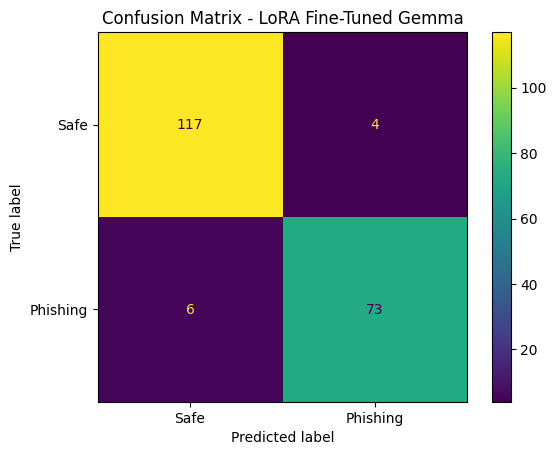

In [12]:
c_matrix = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=["Safe", "Phishing"]).plot()
plt.title('Confusion Matrix - LoRA Fine-Tuned Gemma')
plt.show()

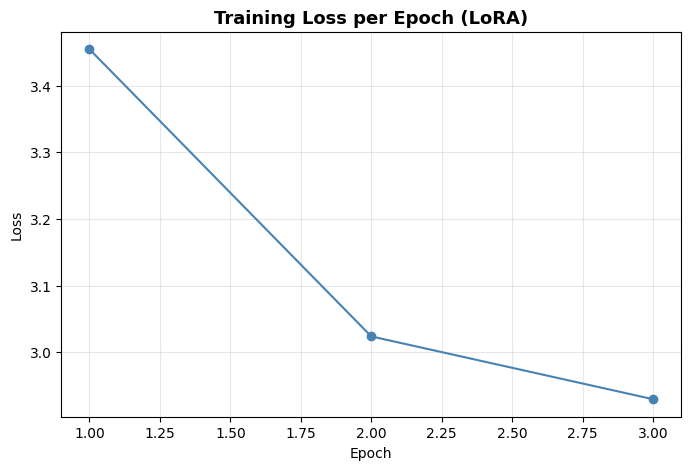

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', color='steelblue')
plt.title('Training Loss per Epoch (LoRA)', fontsize=13, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.show()

## Zero-Shot vs Few-Shot vs LoRA — Comparison

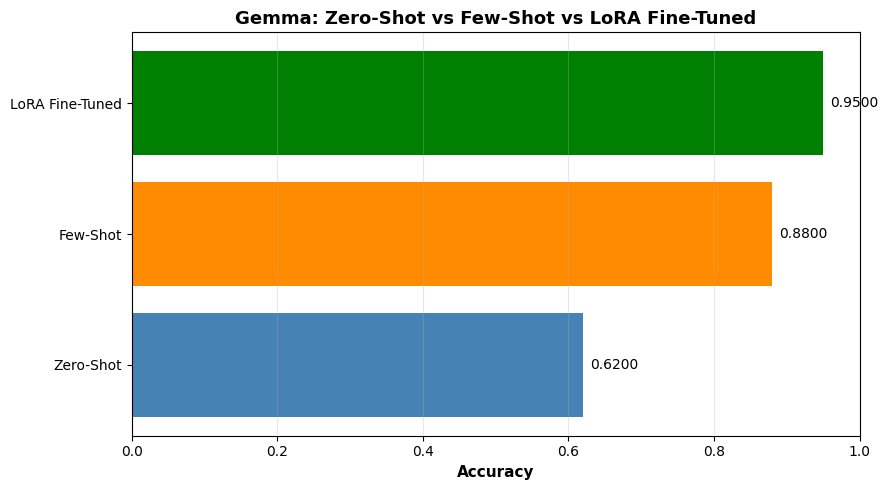

In [15]:
zero_shot_acc = .62   # replace with your result
few_shot_acc  = .88  # replace with your result
lora_acc      = accuracy_score(true_labels, predictions)

methods = ["Zero-Shot", "Few-Shot", "LoRA Fine-Tuned"]
accs    = [zero_shot_acc, few_shot_acc, lora_acc]
colors  = ["steelblue", "darkorange", "green"]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.barh(methods, accs, color=colors)
ax.set_xlabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Gemma: Zero-Shot vs Few-Shot vs LoRA Fine-Tuned', fontsize=13, fontweight='bold')
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

for bar, acc in zip(bars, accs):
    ax.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f"{acc:.4f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Save LoRA Adapters (Optional)
Saves only the small adapter weights — not the full model.

In [17]:
model.save_pretrained("/content/drive/MyDrive/gemma_lora_phishing")
tokenizer.save_pretrained("/content/drive/MyDrive/gemma_lora_phishing")
print("Saved to Google Drive!")

# To reload later:
# base = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map="auto")
# model = PeftModel.from_pretrained(base, "./gemma_lora_phishing")

Saved to Google Drive!
